In [1]:
# %load Avi_Sklearn.py
#!/usr/bin/env python

# In[11]:

from tqdm import tqdm
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor    #### MLP 感知机####
from sklearn.tree import ExtraTreeRegressor        #### ExtraTree极端随机树回归####
from sklearn import tree                           #### 决策树回归####
from sklearn.ensemble import BaggingRegressor      #### Bagging回归####
from sklearn.ensemble import AdaBoostRegressor     #### Adaboost回归
from sklearn import linear_model                   #### 线性回归####
from sklearn import svm                            #### SVM回归####
from sklearn import ensemble                       #### Adaboost回归####  ####3.7GBRT回归####  ####3.5随机森林回归####
from sklearn import neighbors                      #### KNN回归####
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from evaluate_data import *
import openpyxl
import warnings
warnings.filterwarnings("ignore")
datalist = []
# %load sklearn.py
# @Time    : 2021/7/16 0016 19:55
# @Author  : pimaozheng
# @Site    : 
# @File    : 机器学习方法.py
# @Software: PyCharm

def nmindata(dataset,n):
    df = dataset[['timeStamp','ghi']]
    df['timeStamp'] = pd.to_datetime(df['timeStamp'])
    df.set_index('timeStamp', inplace=True)
    df.resample('30T').mean()



def create_data(data, train_num, ahead_num):
    train_num = round(0.8*len(data))
    
    dataX1, dataX2 = [], []
    dataY1, dataY2 = [], []

    for i in range(train_num - ahead_num):
        # print(i)
        a = data[i:(i + ahead_num), 0]
        dataX1.append(a)
    for j in range(train_num - ahead_num, len(data) - ahead_num):
        b = data[j:(j + ahead_num), 0]
        dataX2.append(b)

    dataY1 = data[ahead_num:train_num, 0]
    dataY2 = data[train_num:, 0]
    return np.array(dataX1), np.array(dataY1), np.array(dataX2), np.array(dataY2)
#评价指标
def smape(y_true, y_pred):
    L1 = int(len(y_true))
    L2 = int(len(y_pred))
    # print(L1,L2)
    if L1 == L2:
        # SUM1=sum(abs(true-predict)/abs(true))
        SUM = 0.0
        for i in range(L1):
            a= 2.0*(abs(y_true[i] - y_pred[i]))
            b=np.abs(y_pred[i]) + np.abs(y_true[i])
            SUM=a/b+SUM
        per_SUM = SUM * 100.0
        smape = per_SUM / L1
        return smape


    return 2.0 * np.mean(np.abs(y_pred[i] - y_true[i]) / (np.abs(y_pred[i]) + np.abs(y_true[i]))) * 100
##加载数据
def load_data(filename, ahead_num,n):
    dataset = pd.read_csv(filename,encoding='gbk')
    dataset = pd.DataFrame(dataset)
    dataPOV = dataset[['timeStamp','ghi']]
#     dataPOV.dropna(inplace=True)
    
#     dataset = pd.read_csv(filename,encoding='gbk')
#     dataset = pd.DataFrame(dataset)
#     dataPOV = dataset['ghi']

    
    
    dataPOV['timeStamp'] = pd.to_datetime(dataPOV['timeStamp'])
    dataPOV.set_index('timeStamp', inplace=True)
    dataPOV = dataPOV.resample(f'{n}T').mean()
    dataPOV.dropna(inplace=True)
    
    dataPOV = np.array(dataPOV).reshape(-1,1)
    print("dataPOV:",dataPOV.shape)
    N1=70000
    N2 = N1+10000
    dataAll = dataPOV[:N2,:]
    
    print('NAN:-->',np.argwhere(np.isnan(dataAll)))
    #归一化
    global scaler
    scaler = StandardScaler(copy=True,with_mean=True,with_std=True)
    dataAll = scaler.fit_transform(dataAll)

    trainX, trainY, testX, testY = create_data(dataAll,N1,ahead_num)
    print("trainX", trainX.shape)
    print("trainY", trainY.shape)
    return trainX, trainY, testX, testY   #dataFll

def pre_model(model,trainX,trainY,testX):
    model.fit(trainX,trainY)
    predict = model.predict(testX)
    return predict.reshape(-1, 1)

def main():
    np.random.RandomState(7)
    global ahead_num
    ahead_num = 8
    # #多分钟
    filename =  "Folsom_irradiance.csv"

    for n in tqdm([1,5,10,15,30]):
        x_train, y_train, x_test, y_test = load_data(filename, ahead_num,n)
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)

        print("x_train:",x_train.shape)
        print("y_train:", y_train.shape)
        print("x_test:", x_test.shape)
        print("y_test:", y_test.shape)

    
        ##====================多模型  multi single model
        model_DecisionTreeRegressor = tree.DecisionTreeRegressor()     #决策树
        model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=50)  # 随机森林
        model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=50)  # GDBT
        model_LinearRegression = linear_model.LinearRegression()  # 线性回归
        model_SVR = svm.SVR()                                        # SVR回归
        model_KNeighborsRegressor = neighbors.KNeighborsRegressor()  # KNN回归
        model_ExtraTreeRegressor = ExtraTreeRegressor()  # extra tree
        model_MLP = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(20, 20, 20), random_state=2)  # MLP
        model_BaggingRegressor = BaggingRegressor()   # bggingRegressor
        model_AdaboostRegressor = AdaBoostRegressor() # adaboostRegressor
        ##预测=============predict
        predict_decideTree = pre_model(model_DecisionTreeRegressor,x_train, y_train, x_test)
        print('decideTree completed')
        predict_randomForest = pre_model(model_RandomForestRegressor,x_train, y_train, x_test)
        print('randomForest completed')
        predict_linear = pre_model(model_LinearRegression, x_train, y_train, x_test)
        print('predict_linear completed')
        predict_svr = pre_model(model_SVR, x_train, y_train, x_test)
        print('predict_svr completed')
        predict_kNeighbors = pre_model(model_KNeighborsRegressor, x_train, y_train, x_test)
        print('predict_kNeighbors completed')
        predict_gradientBoosting = pre_model(model_GradientBoostingRegressor, x_train, y_train, x_test)
        print('predict_gradientBoosting completed')
        predict_extraTree = pre_model(model_ExtraTreeRegressor, x_train, y_train, x_test)
        print('predict_extraTree completed')
        predict_mlp = pre_model(model_MLP, x_train, y_train, x_test)

        print('predict_mlp completed')

        predict_bagging = pre_model(model_BaggingRegressor, x_train, y_train, x_test)

        print('predict_bagging completd')
        predict_adaboost = pre_model(model_AdaboostRegressor,x_train,y_train,x_test)

        print('predict_adaboost completd')
        ##===============反归一化
        global scaler
        print('predict_decideTree')
        print(predict_decideTree)
        predict_decideTree = scaler.inverse_transform(predict_decideTree)
        predict_randomForest = scaler.inverse_transform(predict_randomForest)
        predict_linear = scaler.inverse_transform(predict_linear)
        predict_svr = scaler.inverse_transform(predict_svr)
        predict_kNeighbors = scaler.inverse_transform(predict_kNeighbors)
        predict_gradientBoosting = scaler.inverse_transform(predict_gradientBoosting)
        predict_extraTree = scaler.inverse_transform(predict_extraTree)
        predict_mlp = scaler.inverse_transform(predict_mlp)
        predict_bagging = scaler.inverse_transform(predict_bagging)
        predict_adaboost = scaler.inverse_transform(predict_adaboost)

        dataY = scaler.inverse_transform(y_test)

        mae_decideTree = MAE1(dataY,predict_decideTree)
        rmse_decideTree = RMSE1(dataY,predict_decideTree)
        mape_decideTree = MAPE1(dataY,predict_decideTree)
        r2_decideTree = r2_score(dataY, predict_decideTree)
        sampe_decideTree=smape(dataY, predict_decideTree)


    #     print("======================================================")
    #     print("rmse_decideTree:",rmse_decideTree)
    #     print("mape_decideTree:",mape_decideTree)
    #     print("mae_decideTree:",mae_decideTree)
    #     print("R_decideTree",r2_decideTree)
    #     print("sampe_decideTree", sampe_decideTree)

       #  #=======================random forest
        rmse_randomForest = RMSE1(dataY,predict_randomForest)
        mape_randomForest = MAPE1(dataY,predict_randomForest)
        mae_randomForest = MAE1(dataY,predict_randomForest)
        r2_randomForest = r2_score(dataY, predict_randomForest)
        sampe_randomForest = smape(dataY, predict_randomForest)
    #     print("R2_randomForest", r2_randomForest)
        adjust_R = 1 - ((1 - r2_randomForest) * (1000 - 1)) / (1000 - 1 - 1)
    #     print("adjust_R", adjust_R)
    #     print("mae_randomForest:", mae_randomForest)
    #     print("rmse_randomForest:",rmse_randomForest)
    #     print("mape_randomForest:",mape_randomForest)
    #     print("r2_randomForest",r2_randomForest)
    #     print("sampe_randomForest",sampe_randomForest)

        rmse_linear = RMSE1(dataY,predict_linear)
        mape_linear = MAPE1(dataY,predict_linear)
        mae_linear = MAE1(dataY,predict_linear)
        r2_linear = r2_score(dataY, predict_linear)
        smape_linear=smape(dataY, predict_linear)
    #     print("R2_linear", r2_linear)
    #     print("mae_linear:", mae_linear)
    #     print("rmse_linear:", rmse_linear)
    #     print("mape_linear:", mape_linear)
    #     print("smape_linear",smape_linear)

        rmse_svr = RMSE1(dataY,predict_svr)
        mape_svr = MAPE1(dataY,predict_svr)
        mae_svr = MAE1(dataY,predict_svr)
        r2_svr = r2_score(dataY, predict_svr)
        smape_svr=smape(dataY, predict_svr)
    #     print("R2_svr", r2_svr)
    #     print("mae_svr:", mae_svr)
    #     print("rmse_svr:", rmse_svr)
    #     print("mape_svr:", mape_svr)
    #     print("smape_svr",smape_svr)

        rmse_kNeighbors = RMSE1(dataY,predict_kNeighbors)
        mape_kNeighbors = MAPE1(dataY,predict_kNeighbors)
        mae_kNeighbors = MAE1(dataY,predict_kNeighbors)
        r2_kNeighbors = r2_score(dataY, predict_kNeighbors)
        smape_kNeighbors=smape(dataY, predict_kNeighbors)
    #     print("R2_kNeighbors", r2_kNeighbors)
    #     print("mae_kNeighbors:", mae_kNeighbors)
    #     print("rmse_kNeighbors:", rmse_kNeighbors)
    #     print("mape_kNeighbors:", mape_kNeighbors)
    #     print("smape_kNeighbors",smape_kNeighbors)

        rmse_mlp = RMSE1(dataY,predict_mlp)
        mape_mlp = MAPE1(dataY,predict_mlp)
        mae_mlp = MAE1(dataY,predict_mlp)
        r2_mlp = r2_score(dataY, predict_mlp)
        sampe_mlp=smape(dataY, predict_mlp)
    #     print("R2_mlp", r2_mlp)
    #     print("mae_mlp:", mae_mlp)
    #     print("rmse_mlp:", rmse_mlp)
    #     print("mape_mlp:", mape_mlp)
    #     print("sampe_mlp",sampe_mlp)

        rmse_gradientBoosting = RMSE1(dataY,predict_gradientBoosting)
        mape_gradientBoosting = MAPE1(dataY,predict_gradientBoosting)
        mae_gradientBoosting = MAE1(dataY,predict_gradientBoosting)
        r2_gradientBoosting  = r2_score(dataY, predict_gradientBoosting)
        sampe_gradientBoosting=smape(dataY,predict_gradientBoosting)
    #     print("R2_gradientBoosting ", r2_gradientBoosting )
    #     print("mae_gradientBoosting:", mae_gradientBoosting)
    #     print("rmse_gradientBoosting:", rmse_gradientBoosting)
    #     print("mape_gradientBoosting:", mape_gradientBoosting)
    #     print("sampe_gradientBoosting",sampe_gradientBoosting)

        rmse_extraTree = RMSE1(dataY,predict_extraTree)
        mape_extraTree = MAPE1(dataY,predict_extraTree)
        mae_extraTree = MAE1(dataY,predict_extraTree)
        r2_extraTree = r2_score(dataY, predict_extraTree)
        sampe_extraTree=smape(dataY, predict_extraTree)
    #     print("R2_extraTree ", r2_extraTree)
    #     print("mae_extraTree:", mae_extraTree)
    #     print("rmse_extraTree:", rmse_extraTree)
    #     print("mape_extraTree:", mape_extraTree)
    #     print("sampe_extraTree",sampe_extraTree)

        rmse_bagging = RMSE1(dataY,predict_bagging)
        mape_bagging = MAPE1(dataY,predict_bagging)
        mae_bagging = MAE1(dataY,predict_bagging)
        r2_bagging = r2_score(dataY, predict_bagging)
        smape_bagging=smape(dataY,predict_bagging)
    #     print("R2_bagging ", r2_bagging)
    #     print("mae_bagging:", mae_bagging)
    #     print("rmse_bagging:", rmse_bagging)
    #     print("mape_bagging:", mape_bagging)
    #     print("smape_bagging",smape_bagging)

        rmse_adaboost = RMSE1(dataY,predict_adaboost)
        mape_adaboost = MAPE1(dataY,predict_adaboost)
        mae_adaboost = MAE1(dataY,predict_adaboost)
        r2_adaboost = r2_score(dataY, predict_adaboost)
    #     print("R2_adaboost ", r2_adaboost)
    #     print("mae_adaboost:", mae_adaboost)
    #     print("rmse_bagging:", rmse_adaboost)
    #     print("mape_adaboost:", mape_adaboost)


    #     ###===============画图===========================
    
        datalist.append((dataY[:],predict_mlp,predict_svr,predict_linear,predict_mlp,predict_gradientBoosting))
#         plt.figure(1,figsize=(15, 4))

#         plt.plot(dataY[:], "black", label="True",linewidth=3, linestyle='--', marker='.')
#         plt.plot(predict_mlp, "peru", label="MLP")

#         #plt.plot(predict_lstm[:], "r", label="lstm",linewidth=1)
#         plt.plot(predict_svr, "aqua", label="SVR",linewidth=1.25)
#         plt.plot( predict_linear, "y", label="linear")
#         plt.plot(predict_mlp, "k", label="mlp")
#         plt.plot(predict_gradientBoosting, "b", label="gdB")
#         plt.title(f"Graph for {n} min data")
#         # plt.xlabel("60min")
#         # plt.ylabel("GHI")
#        # plt.title(str(N1)+"min")
#         plt.legend(loc='best')
#     #    plt.savefig("resultdata_timeSeries\\"+season+"\\"+str(minLen)+"min"+"\\"+season+"_pov_"+str(N1)+"point.png", bbox_inches='tight')  # fig.savefig
#         plt.show()

if __name__=="__main__":

    main()


# In[ ]:



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

dataPOV: (533479, 1)
NAN:--> []
trainX (63992, 8)
trainY (63992,)
x_train: (63992, 8)
y_train: (63992, 1)
x_test: (16000, 8)
y_test: (16000, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost completd
predict_decideTree
[[0.03060157]
 [0.04117235]
 [0.05420965]
 ...
 [1.67647223]
 [1.56371723]
 [1.54962286]]


 20%|████████████████▌                                                                  | 1/5 [01:49<07:17, 109.33s/it]

dataPOV: (107262, 1)
NAN:--> []
trainX (63992, 8)
trainY (63992,)
x_train: (63992, 8)
y_train: (63992, 1)
x_test: (16000, 8)
y_test: (16000, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost completd
predict_decideTree
[[-1.03616614]
 [-1.0803426 ]
 [-1.04741539]
 ...
 [ 1.39367161]
 [ 1.3837458 ]
 [ 1.3513215 ]]


 40%|█████████████████████████████████▏                                                 | 2/5 [05:22<07:01, 140.54s/it]

dataPOV: (53996, 1)
NAN:--> []
trainX (43189, 8)
trainY (43189,)
x_train: (43189, 8)
y_train: (43189, 1)
x_test: (10799, 8)
y_test: (10799, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost completd
predict_decideTree
[[-1.11833519]
 [-1.26701136]
 [-1.30267302]
 ...
 [-1.23723433]
 [-1.33587095]
 [-1.34432827]]


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [08:04<04:54, 147.00s/it]

dataPOV: (36258, 1)
NAN:--> []
trainX (28998, 8)
trainY (28998,)
x_train: (28998, 8)
y_train: (28998, 1)
x_test: (7252, 8)
y_test: (7252, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost completd
predict_decideTree
[[-1.11945906]
 [-1.29312396]
 [-1.33404628]
 ...
 [-0.93062069]
 [-1.22909215]
 [-1.30047821]]


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [09:39<02:11, 131.22s/it]

dataPOV: (18495, 1)
NAN:--> []
trainX (14788, 8)
trainY (14788,)
x_train: (14788, 8)
y_train: (14788, 1)
x_test: (3699, 8)
y_test: (3699, 1)
decideTree completed
randomForest completed
predict_linear completed
predict_svr completed
predict_kNeighbors completed
predict_gradientBoosting completed
predict_extraTree completed
predict_mlp completed
predict_bagging completd
predict_adaboost completd
predict_decideTree
[[-0.08340235]
 [ 0.24749322]
 [ 0.18114597]
 ...
 [-0.94741866]
 [-1.10897124]
 [-1.28678418]]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:20<00:00, 124.05s/it]


In [6]:
for Y,mlp,svr,linear,mlp,gradientBoosting in [datalist[0]]:
    print('kk')

kk


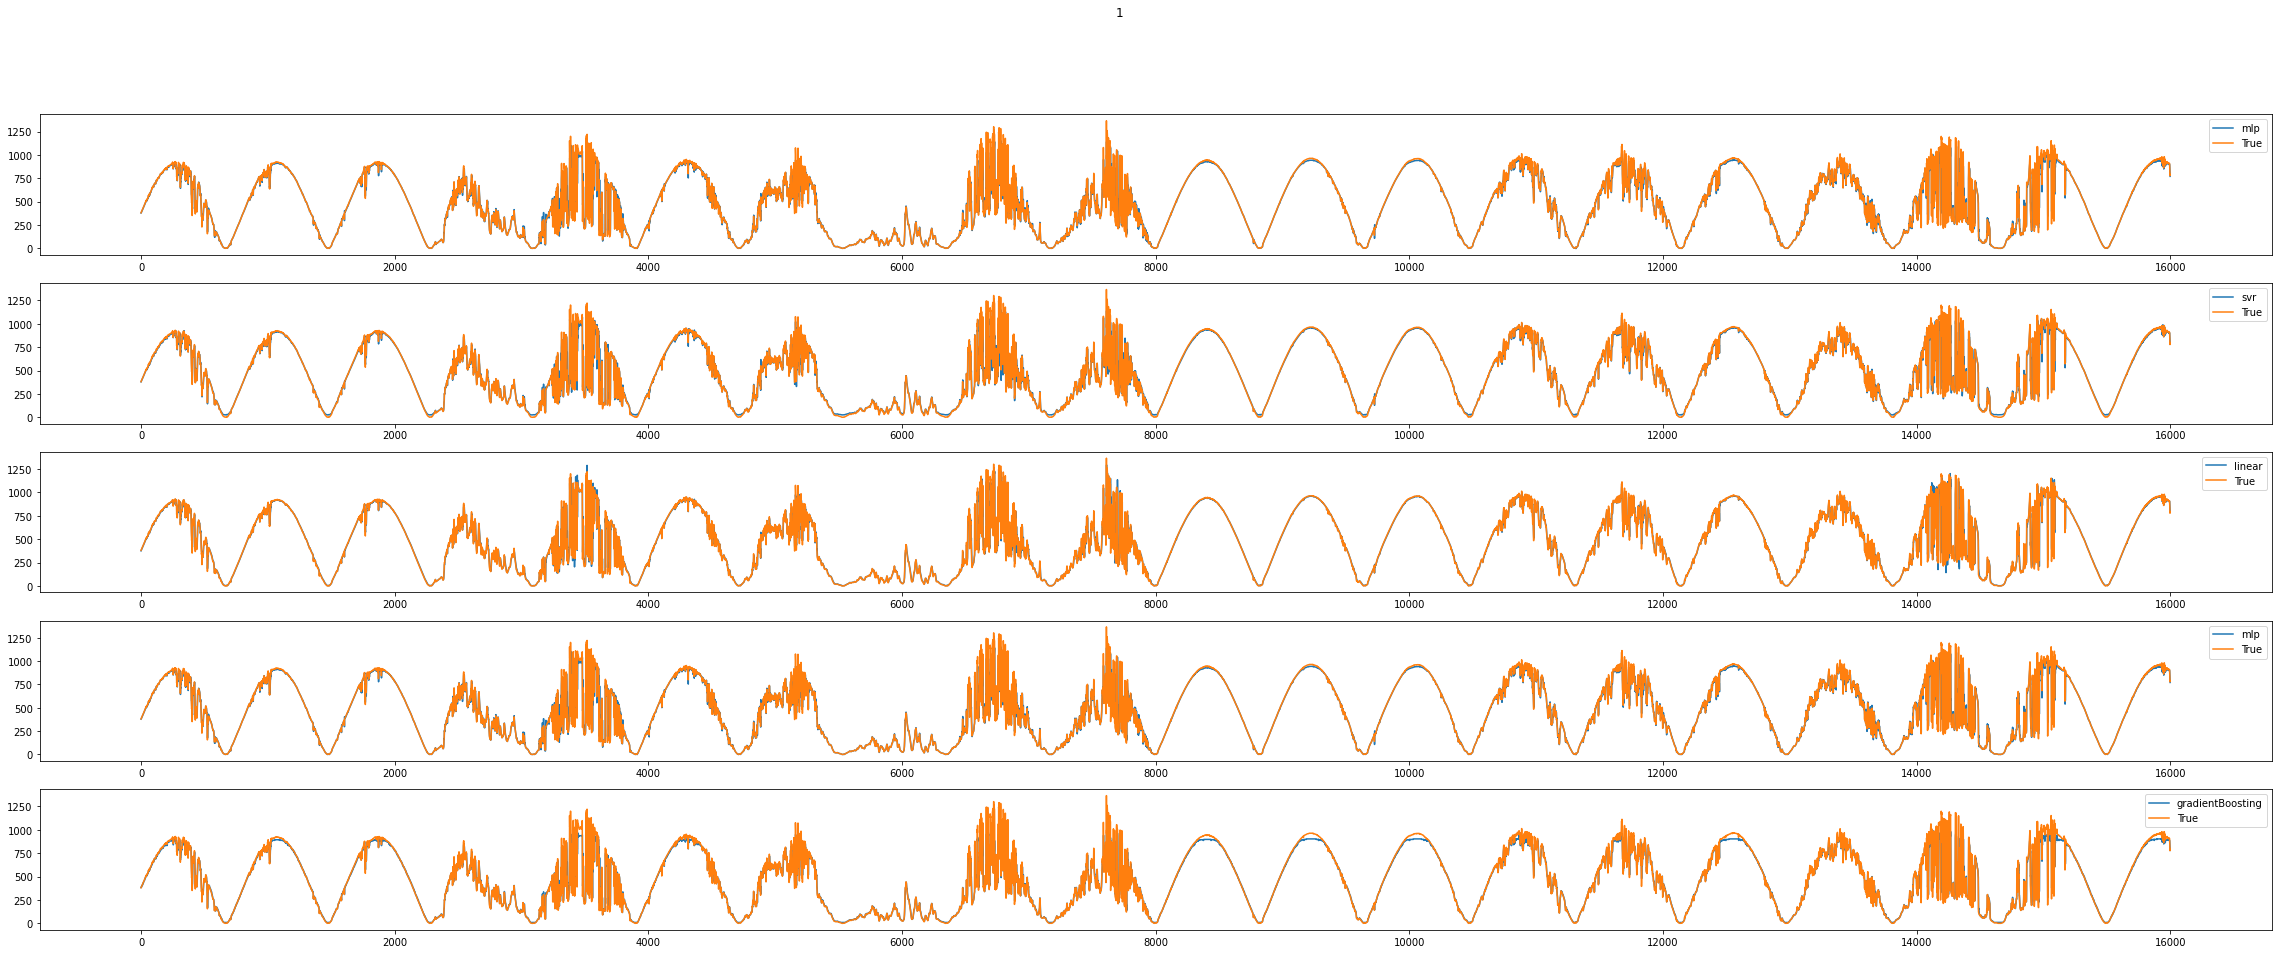

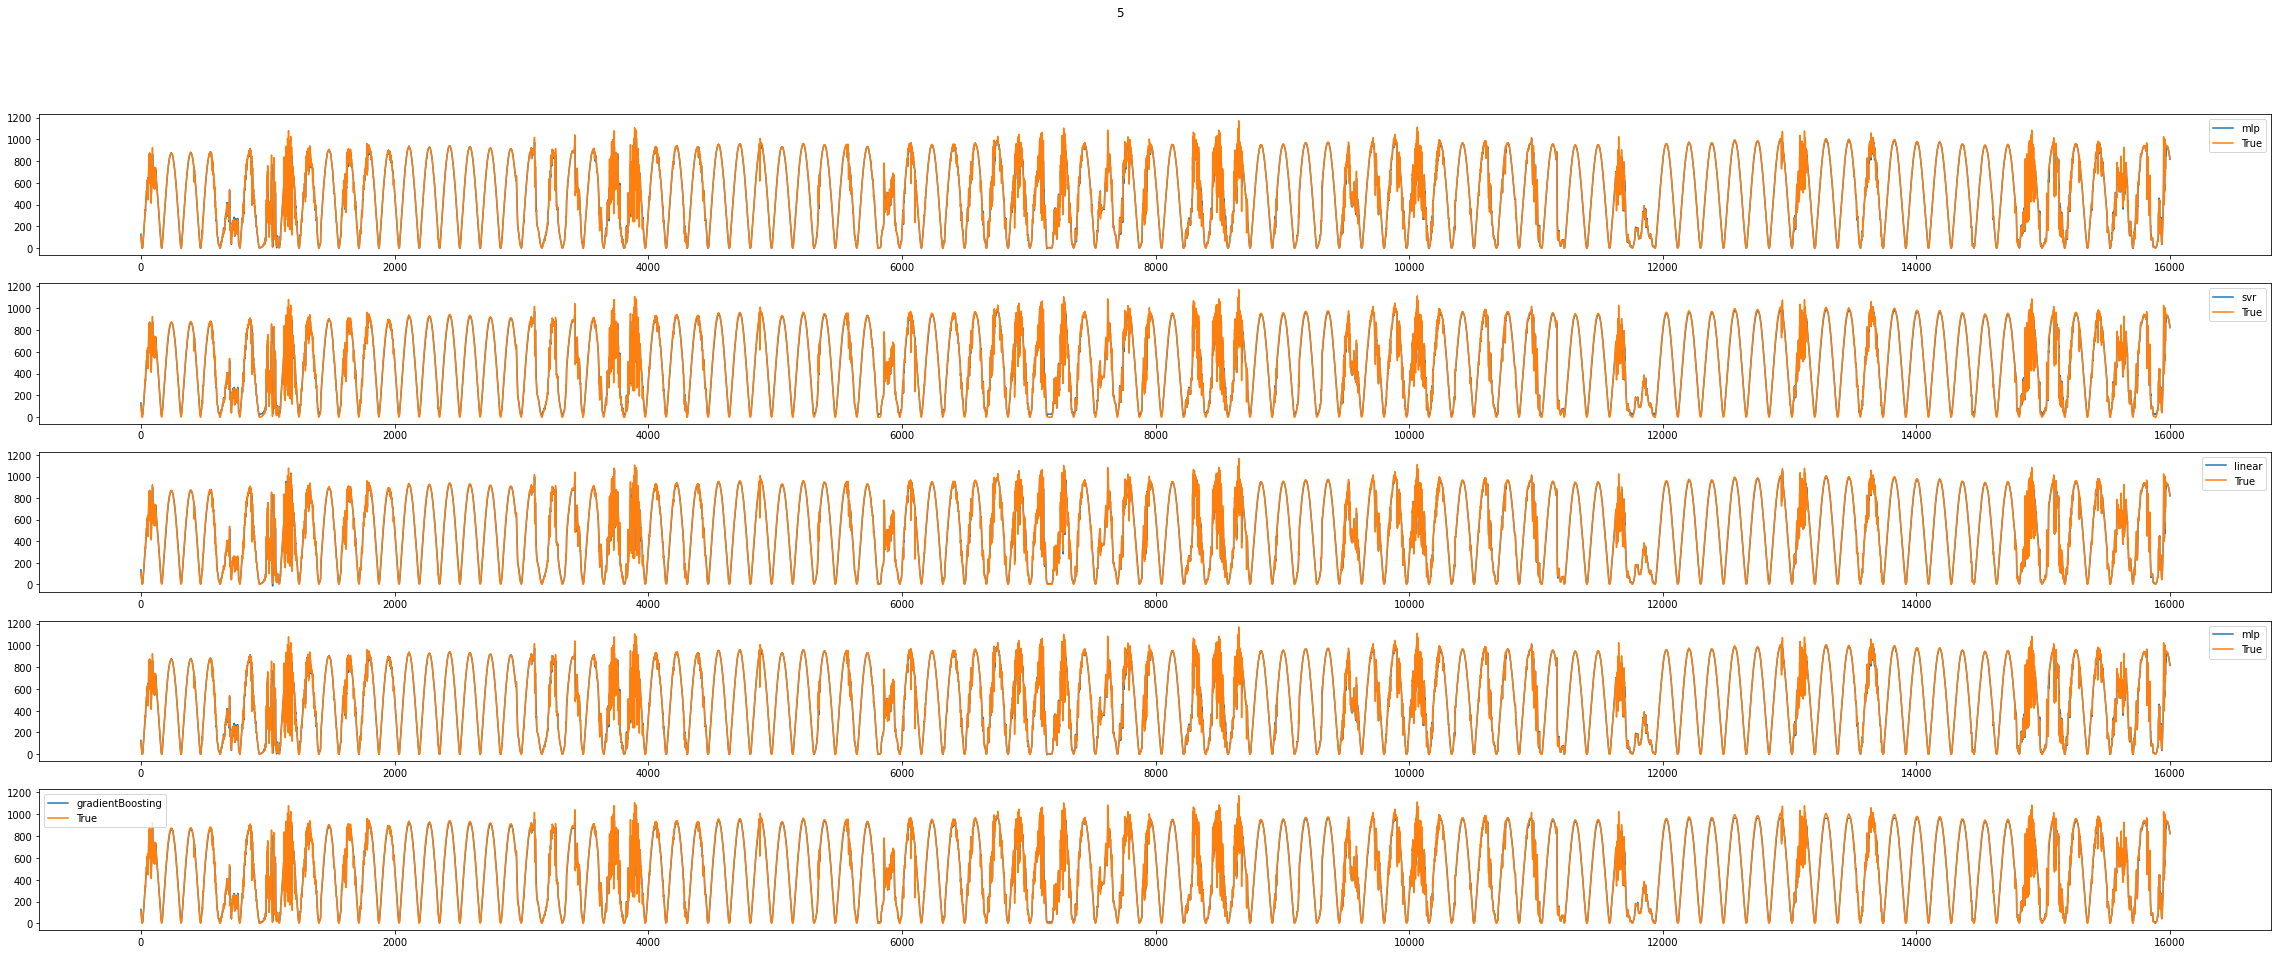

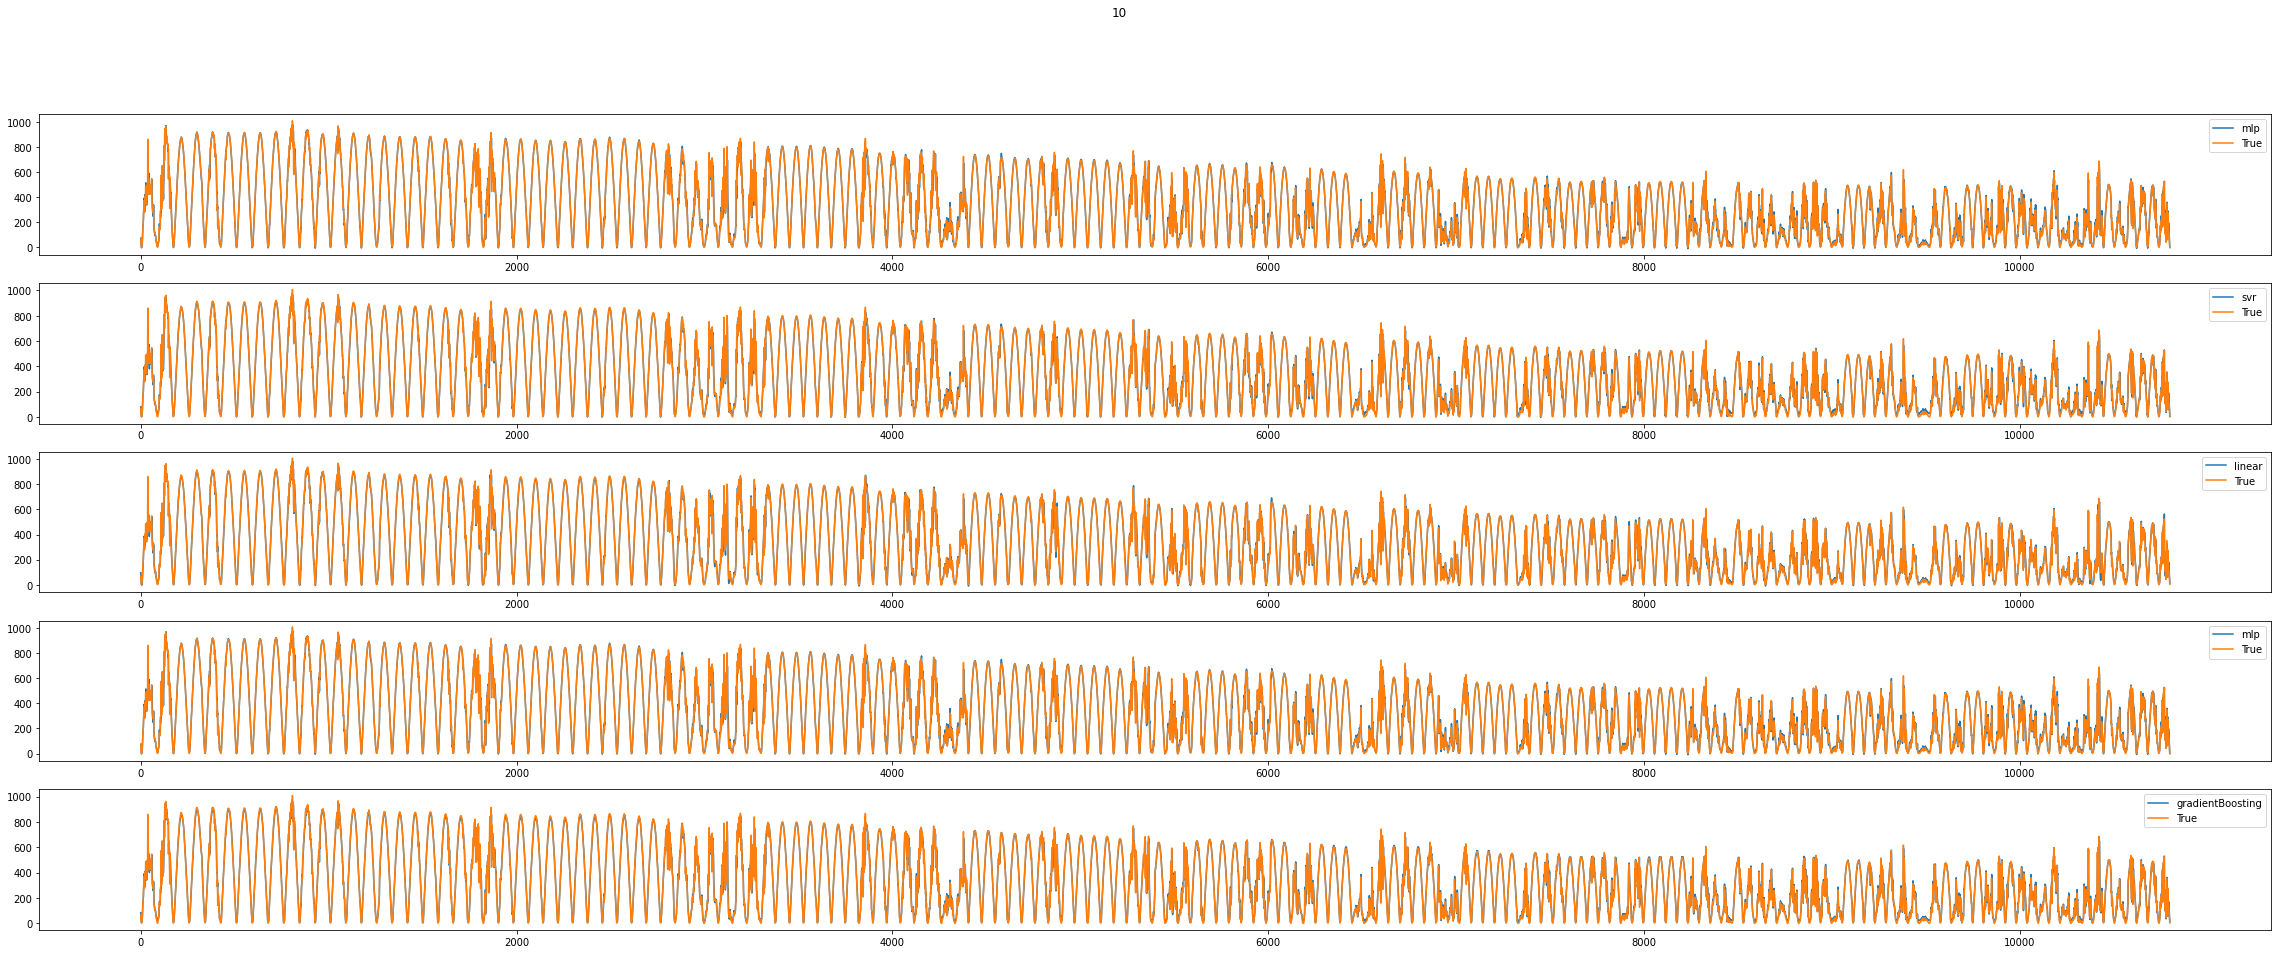

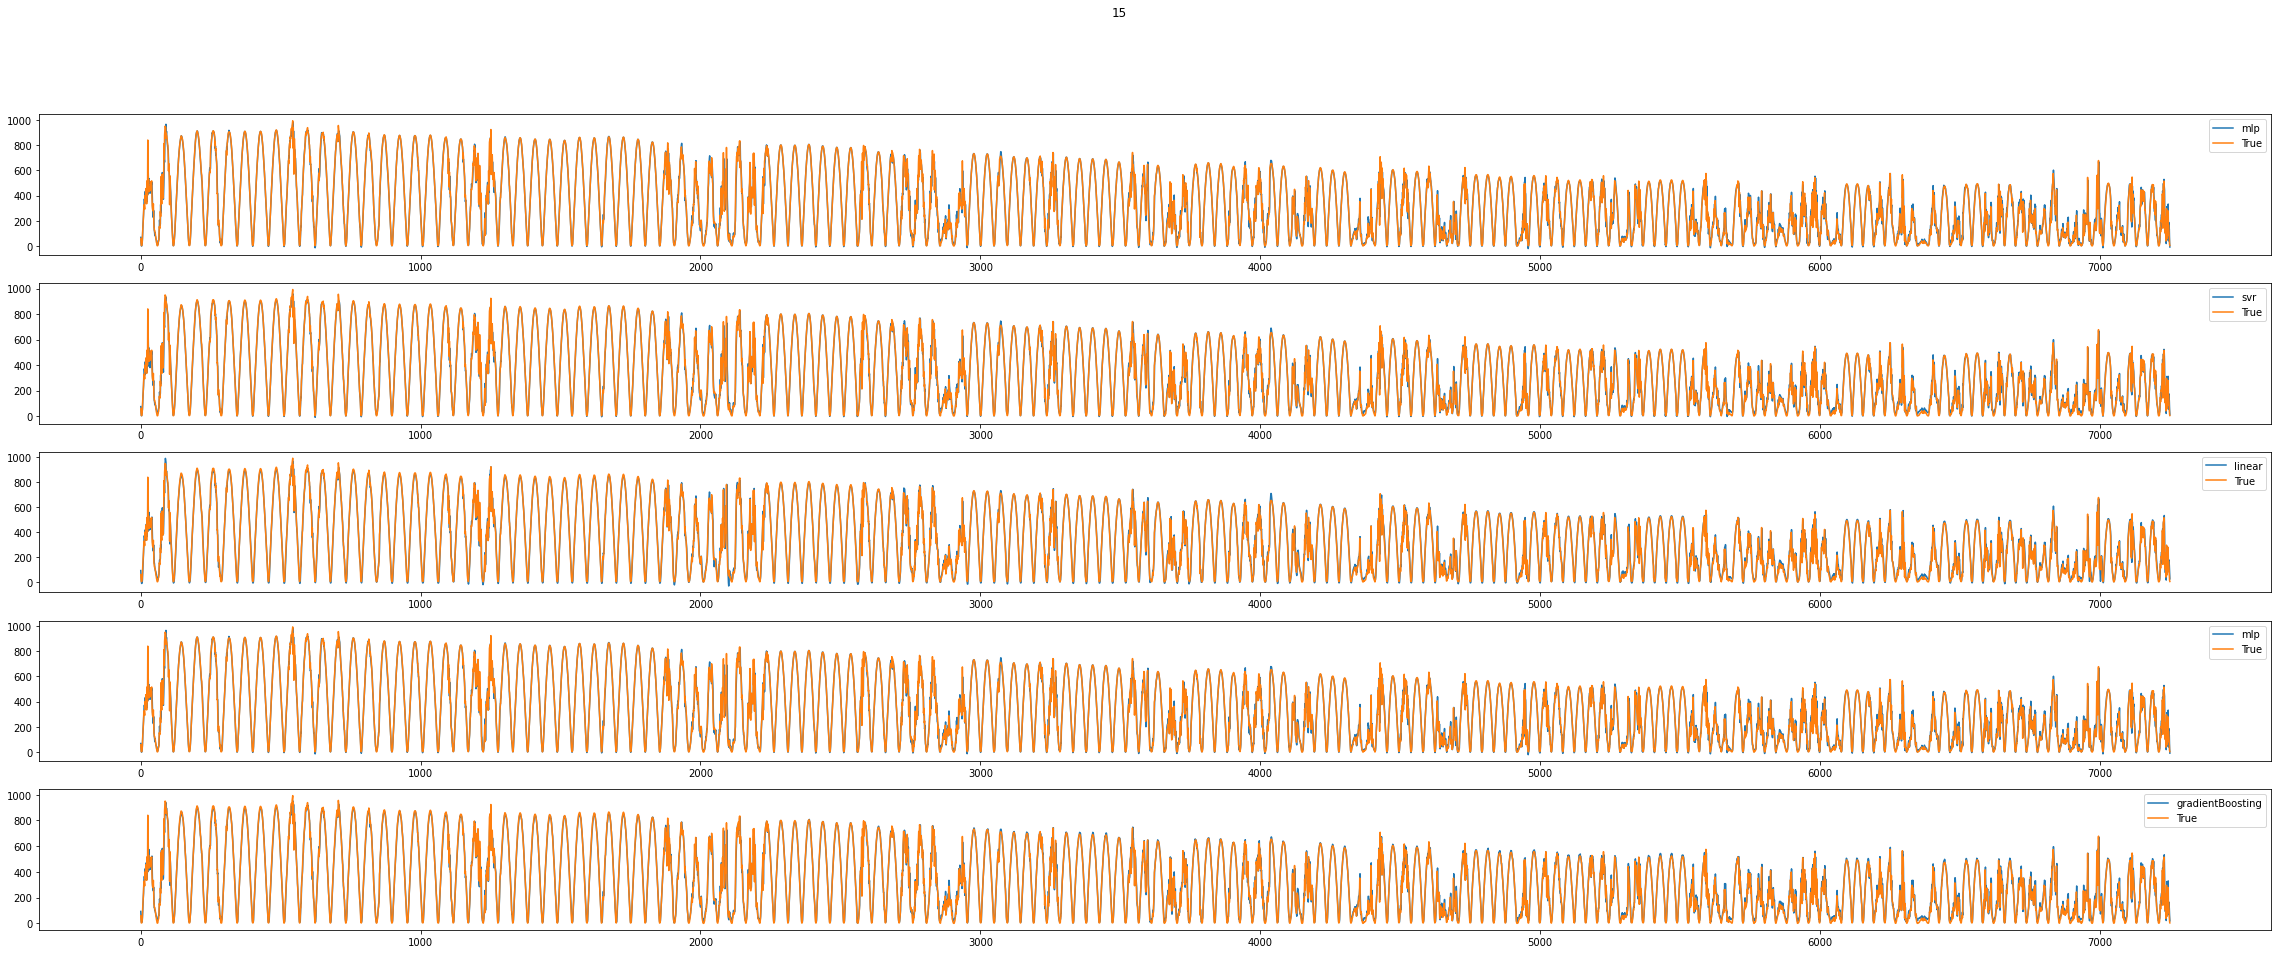

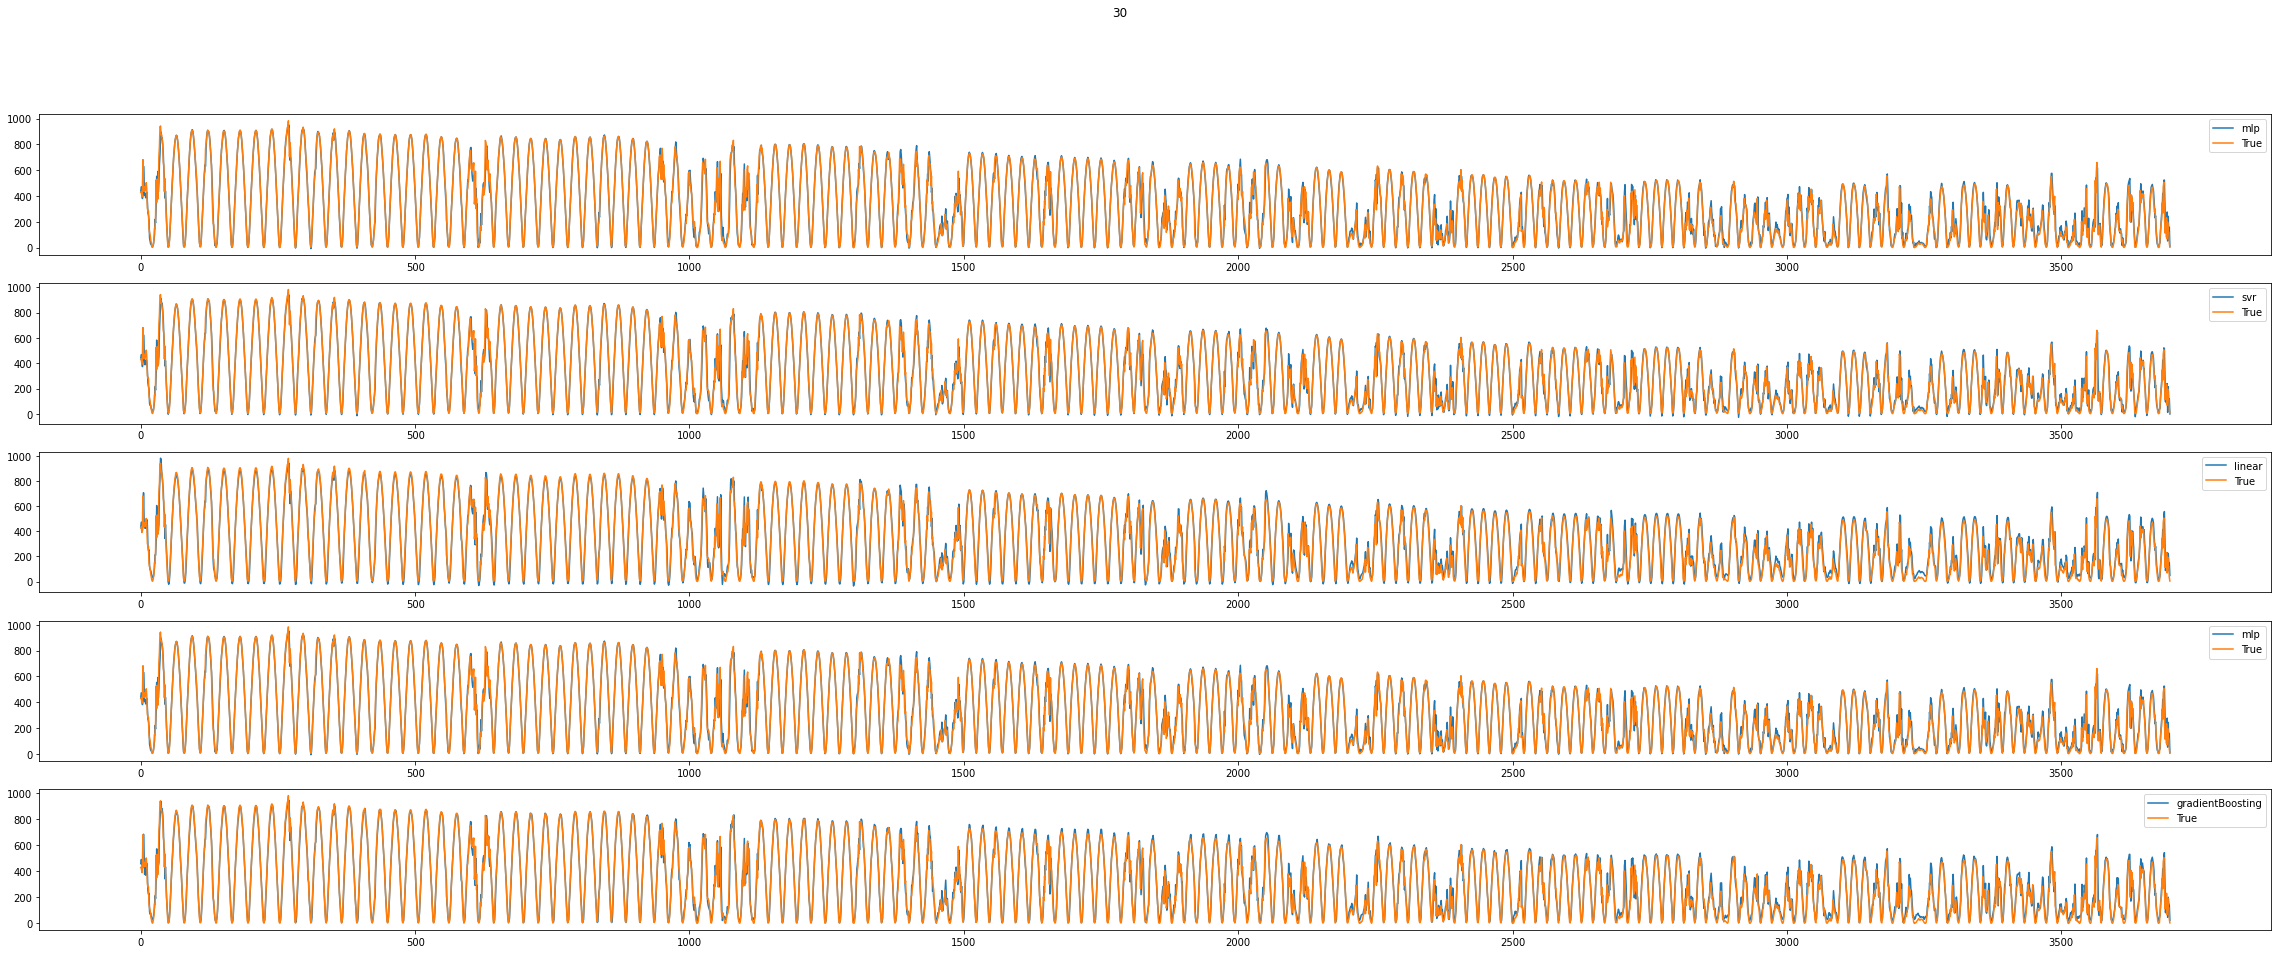

In [18]:
# fig, ax = plt.subplots(5,figsize=(10,10))
i=0
j = 0
s = [1,5,10,15,30]
for Y,mlp,svr,linear,mlp,gradientBoosting in datalist:
    fig, ax = plt.subplots(5,figsize=(40,15))
    ax[i].plot(mlp,label='mlp')
    ax[i].plot(Y,label='True')
    ax[i].legend()

    ax[i+1].plot(svr,label='svr')
    ax[i+1].plot(Y,label='True')
    ax[i+1].legend()
    
    ax[i+2].plot(linear,label='linear')
    ax[i+2].plot(Y,label='True')
    ax[i+2].legend()
    
    ax[i+3].plot(mlp,label='mlp')
    ax[i+3].plot(Y,label='True')
    ax[i+3].legend()
    
    ax[i+4].plot(gradientBoosting,label='gradientBoosting')
    ax[i+4].plot(Y,label='True')
    ax[i+4].legend()
    fig.suptitle(s[j])
    j = j + 1
    

In [30]:
dataset = pd.read_csv('Folsom_irradiance.csv',encoding='gbk')
dataset = pd.DataFrame(dataset)
dataPOV = dataset['ghi']
dataPOV = np.array(dataPOV).reshape(-1,1)
print("dataPOV:",dataPOV.shape)
N1=70000
N2 = N1+10000
dataAll = dataPOV[:N2,:]
#归一化
global scaler
scaler = StandardScaler(copy=True,with_mean=True,with_std=True)
dataAll = scaler.fit_transform(dataAll)

trainX, trainY, testX, testY = create_data(dataAll,N1,ahead_num)

dataPOV: (533479, 1)


In [34]:
dataAll[:16]
a = []
for i in range(train_num - 8):
    # print(i)
    a.append(dataAll[i:(i + ahead_num), 0])

array([[-1.30068263],
       [-1.30068263],
       [-1.30033027],
       [-1.29814565],
       [-1.29744093],
       [-1.2952563 ],
       [-1.2943754 ],
       [-1.29183841],
       [-1.30720128],
       [-1.30582708],
       [-1.30434717],
       [-1.30265585],
       [-1.30036551],
       [-1.29779329],
       [-1.29518583],
       [-1.29264884]])

In [47]:
i=1
ahead_num = 8
dataAll[i:(i + ahead_num), 0]

array([-1.30068263, -1.30033027, -1.29814565, -1.29744093, -1.2952563 ,
       -1.2943754 , -1.29183841, -1.30720128])

In [48]:
dataAll[1:1+8].T

array([[-1.30068263, -1.30033027, -1.29814565, -1.29744093, -1.2952563 ,
        -1.2943754 , -1.29183841, -1.30720128]])

In [50]:
dataAll[ahead_num:10, 0]

array([-1.30720128, -1.30582708])

In [52]:
dataAll[:11].T

array([[-1.30068263, -1.30068263, -1.30033027, -1.29814565, -1.29744093,
        -1.2952563 , -1.2943754 , -1.29183841, -1.30720128, -1.30582708,
        -1.30434717]])

In [38]:
d = pd.DataFrame(trainX)

In [39]:
d['Target'] = trainY

In [41]:
d.head(10)

0         1         2         3         4         5         6  \
0 -1.300683 -1.300683 -1.300330 -1.298146 -1.297441 -1.295256 -1.294375   
1 -1.300683 -1.300330 -1.298146 -1.297441 -1.295256 -1.294375 -1.291838   
2 -1.300330 -1.298146 -1.297441 -1.295256 -1.294375 -1.291838 -1.307201   
3 -1.298146 -1.297441 -1.295256 -1.294375 -1.291838 -1.307201 -1.305827   
4 -1.297441 -1.295256 -1.294375 -1.291838 -1.307201 -1.305827 -1.304347   
5 -1.295256 -1.294375 -1.291838 -1.307201 -1.305827 -1.304347 -1.302656   
6 -1.294375 -1.291838 -1.307201 -1.305827 -1.304347 -1.302656 -1.300366   
7 -1.291838 -1.307201 -1.305827 -1.304347 -1.302656 -1.300366 -1.297793   
8 -1.307201 -1.305827 -1.304347 -1.302656 -1.300366 -1.297793 -1.295186   
9 -1.305827 -1.304347 -1.302656 -1.300366 -1.297793 -1.295186 -1.292649   

          7    Target  
0 -1.291838 -1.307201  
1 -1.307201 -1.305827  
2 -1.305827 -1.304347  
3 -1.304347 -1.302656  
4 -1.302656 -1.300366  
5 -1.300366 -1.297793  
6 -1.297793 -1.295186  
7 -1.295186 -1.292649  
8 -1.292649 -1.289196  
9 -1.289196 -1.285602